In [12]:
%matplotlib inline

from __future__ import print_function

import sys
import logging
from logging.config import dictConfig
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it
import collections as cl
import multiprocessing
import bisect

from numba import jit

import pgenlib as pg

logging_config = dict(
    version = 1,
    formatters = {
        'f': {'format':
              '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'}
        },
    handlers = {
        'h': {'class': 'logging.StreamHandler',
              'formatter': 'f',
              'level': logging.DEBUG}
        },
    root = {
        'handlers': ['h'],
        'level': logging.DEBUG,
        },
)
dictConfig(logging_config)

In [2]:
logger_nb = logging.getLogger('notebook')
logger_nb.info('hello')

2017-06-26 14:04:33,048 notebook     INFO     hello


In [5]:
data_dir='/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/'
geno_bed_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.log'
block_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.log'
pgen_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-pg.log'
pgen_f = '{}{}.pgen'.format(data_dir, pgen_log[:-4])
block_bed_f = '{}{}.bed'.format(data_dir, block_log[:-4])

In [11]:
block_bed = pd.read_csv(block_bed_f, sep='\t', names=['chrom', 'chromStart', 'chromEnd', 'name'])
block_bed['bim_interval'] = block_bed.name.map(lambda x: [int(pos) for pos in x.split(':')])
block_bed['bim_interval_l'] = block_bed.bim_interval.map(lambda x: x[0])
block_bed.head()

,chrom,chromStart,chromEnd,name,bim_interval,bim_interval_l
0,chr20,61097,94952,0:86,"[0, 86]",0
1,chr20,94952,266792,86:938,"[86, 938]",86
2,chr20,266792,288776,938:1027,"[938, 1027]",938
3,chr20,288776,344631,1027:1270,"[1027, 1270]",1027
4,chr20,344631,346676,1270:1277,"[1270, 1277]",1270


In [7]:
read_dir='/oak/stanford/groups/mrivas/public_data/nanopore-wgs-consortium/rel3/hg19/chr20'
#hap_f='{}/rel3.chr20.12500.10k-chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.hap'
hap_f='{}/rel3.chr20.12500.10k-chr20impv1-keep-maf0005-snv-biallelic.hap'.format(read_dir)

In [41]:
with open(hap_f, 'r') as f:
    line = f.readline().rstrip().split('\t')

In [43]:
line

['chr20',
 '59980',
 '65177',
 '33ecb953-edd6-445b-87da-85c4551d8c8c_Basecall_Alignment_template',
 '60',
 '1.442407e-03',
 '0',
 '9',
 '111111101']

In [44]:
def find_ld_blocks(line, block_bed):
    """Take one line of a hap file, and return an interval of blocks
    For example, if the first read in the halplotype has bim_interval [0, 9)
    and the first block spans SNPs [0, 86), this function should return [0, 1)
    """
    return (
        bisect.bisect_right(block_bed.bim_interval_l.as_matrix(), int(line[6])) - 1,
        bisect.bisect_right(block_bed.bim_interval_l.as_matrix(), int(line[7]))
    )

In [67]:
def find_observation(line):
    obs1d = np.array([int(x) for x in list(line[-1])], dtype=np.int8)
    return obs1d.reshape((1, len(obs1d)))

In [56]:
def find_read_specific_error_rate(line):
    return float(line[5])

In [38]:
find_ld_blocks(line, block_bed)

(0, 1)

In [70]:
find_observation(line)

array([[1, 1, 1, 1, 1, 1, 1, 0, 1]], dtype=int8)

In [57]:
find_read_specific_error_rate(line)

0.001442407

In [59]:
cnt0 = np.load(
    '/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/tmp/cnt0.npz', 
)

In [60]:
cnt0.files

['keys', 'vals']

In [61]:
cnt0['keys'].shape

(5144, 86)

In [62]:
cnt0['vals'].shape

(5144,)

In [66]:
cnt0['keys'][:, 0:9].shape

(5144, 9)

In [76]:
(cnt0['keys'][:, 0:9] != find_observation(line)).shape

(5144, 9)

In [77]:
cnt0['keys'][0, 0:9] != find_observation(line)

array([[False, False, False, False,  True, False, False,  True, False]], dtype=bool)

In [78]:
cnt0['keys'][0, 0:9]

array([1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8)

In [79]:
find_observation(line)

array([[1, 1, 1, 1, 1, 1, 1, 0, 1]], dtype=int8)

In [81]:
mismatchs = np.sum(cnt0['keys'][:, 0:9] != find_observation(line), axis=1)

(array([    4.,  1766.,  1094.,  1344.,   438.,   284.,   214.,     0.,
            0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

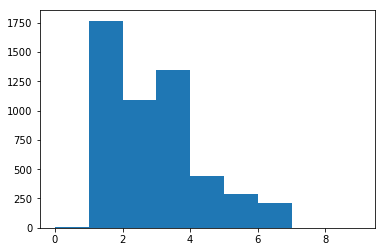

In [85]:
plt.hist(mismatchs, bins=range(0, 10))